In [1]:
# Imports and plotting setups
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math

import sys, os
sys.path.insert(0, '../../')
sys.path.insert(0, '../')

import math_funcs

from cycler import cycler

default_cycler = (cycler(color=['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', 'black']) +
                cycler(linestyle=['-', '--', ':', '-.', '-', '--', ':']))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

#plt.rcParams["font.family"] = "Times"
plt.rcParams["font.size"] = 8

plt.rcParams['figure.figsize'] = (3.5, 2.5)
plt.rcParams['figure.dpi'] = 200

plt.rcParams['text.usetex'] = True

from scipy.constants import (
    epsilon_0,   # Permittivity of free space (vacuum)
    mu_0,        # Permeability of free space (vacuum)
    c,           # Speed of light in vacuum
    #e,           # Elementary charge
    #h,           # Planck constant
    #hbar,        # Reduced Planck constant (h-bar)
    k,           # Boltzmann constant
    #G,           # Newtonian constant of gravitation
    #m_e,         # Electron mass
    #m_p,         # Proton mass
    #m_n,         # Neutron mass
    #alpha,       # Fine-structure constant
    eV,          # Electron volt
)

# Example usage of some constants
print(f"Permittivity of free space: {epsilon_0} F/m")
print(f"Permeability of free space: {mu_0} N/A^2")
print(f"Speed of light in vacuum: {c} m/s")
# print(f"Elementary charge: {e} C")
# print(f"Planck constant: {h} J·s")
# print(f"Reduced Planck constant: {hbar} J·s")
print(f"Boltzmann constant: {k} J/K")
# print(f"Newtonian constant of gravitation: {G} m^3/kg/s^2")
# print(f"Electron mass: {m_e} kg")
# print(f"Proton mass: {m_p} kg")
# print(f"Neutron mass: {m_n} kg")
# print(f"Fine-structure constant: {alpha}")
print(f"Electron volt: {eV} J")

def print_engineering_notation(value):
    """
    Print a value in engineering notation (powers of ten in multiples of 3).

    Parameters:
    value (float): The value to be printed in engineering notation.
    """
    
    if value == 0:
        print("0")
        return

    exponent = int(math.floor(math.log10(abs(value)) / 3) * 3)
    mantissa = value / (10 ** exponent)
    
    print(f"{mantissa:.3f}e{exponent}")

# Example usage
print_engineering_notation(0)          # Output: 0
print_engineering_notation(1234.56)    # Output: 1.235e3
print_engineering_notation(0.00123456) # Output: 1.235e-3
print_engineering_notation(-987654)    # Output: -987.654e3
print_engineering_notation(1e9)        # Output: 1.000e9

Permittivity of free space: 8.8541878128e-12 F/m
Permeability of free space: 1.25663706212e-06 N/A^2
Speed of light in vacuum: 299792458.0 m/s
Boltzmann constant: 1.380649e-23 J/K
Electron volt: 1.602176634e-19 J
0
1.235e3
1.235e-3
-987.654e3
1.000e9


In [3]:
#Define coldspace, jovian, gal radiation field for a mission 
T_B_J_low_band = 10**11 #K
T_B_J_high_band = 10**2 # K
T_B_gal_low_band = 10**7 # K
T_B_gal_high_band = T_B_J_high_band
T_B_coldspace = 2.7 #K

In [4]:
# Define a function to resample to the 1 deg find 
# grid to 10 deg course grid that the antenna pattern is using
class angle_grid:
    def __init__(self, dtheta, dphi):
        self.dtheta = dtheta
        self.dphi = dphi

        self.theta_resample = np.arange(0, 180+dtheta, dtheta, dtype=int) # deg
        self.phi_resample = np.arange(0, 360+dphi, dphi, dtype=int) # deg

        self.phi_grid_resample, \
            self.theta_grid_resample = \
                np.meshgrid(self.phi_resample, self.theta_resample)
        
    def get_angle_grid(self):
        return self.theta_resample, self.phi_resample, \
            self.phi_grid_resample, self.theta_grid_resample

def resample_course(T_B, return_grids=False):
    # Define the course theta and phi sampling grid
    theta_resample, phi_resample, \
        phi_grid_resample, theta_grid_resample = angle_grid(10, 10).get_angle_grid()

    # Resample and reweight the sampling grid points
    T_B_resample = np.zeros_like(theta_grid_resample, dtype=float).flatten()
    for i in np.arange(theta_grid_resample.size):
        theta = theta_grid_resample.flatten()[i]
        phi = phi_grid_resample.flatten()[i]

        theta_range = (theta + np.arange(-5, 5, 1)) % 180
        phi_range = (phi + np.arange(-5, 5, 1)) % 360
        dsteradian = 100
        for sub_theta in theta_range:
            for sub_phi in phi_range:
                T_B_resample[i] += T_B[sub_theta, sub_phi]

        T_B_resample[i] = T_B_resample[i] / dsteradian

    T_B_resample = T_B_resample.reshape(theta_grid_resample.shape)

    if return_grids:
        return T_B_resample, theta_resample, phi_resample, theta_grid_resample, phi_grid_resample
    else:
        return T_B_resample

In [6]:
# Brightness Field For the SubJovian point

# The orientation of the coordinate system is taken such that
# Europa's equator is theta==90, and all phi
# The sub Jovian point is located at theta==90, phi==0
# The anti Jovian point is located at theta==90, phi==180
# The north pole is located at theta==0
# The south pole is located at theta==180

# Define the theta and phi fine sampling grid
theta, phi, \
    phi_grid, theta_grid  = angle_grid(1, 1).get_angle_grid()

# Define the brightness grid with vertical and horizontal polarization
T_Bv_low_band = np.zeros_like(theta_grid, dtype=float).flatten()
T_Bh_low_band = np.zeros_like(theta_grid, dtype=float).flatten()
T_Bv_high_band = np.zeros_like(theta_grid, dtype=float).flatten()
T_Bh_high_band = np.zeros_like(theta_grid, dtype=float).flatten()

for i in np.arange(theta_grid.size):
    theta = theta_grid.flatten()[i]
    phi = phi_grid.flatten()[i]
    
    # Addition of cold space background everywhere
    T_Bv_low_band[i] += 0.5 * T_B_coldspace
    T_Bh_low_band[i] += 0.5 * T_B_coldspace
    T_Bv_high_band[i] += 0.5 * T_B_coldspace
    T_Bh_high_band[i] += 0.5 * T_B_coldspace

    # Draw the galactic background
    if theta >= 105 and theta <= 135:
        if phi >= 180 and phi <= 360:
            T_Bv_low_band[i] += 0.5 * T_B_gal_low_band
            T_Bh_low_band[i] += 0.5 * T_B_gal_low_band
            T_Bv_high_band[i] += 0.5 * T_B_gal_high_band
            T_Bh_high_band[i] += 0.5 * T_B_gal_high_band

    # DAM radiation illumination 
    # from aural regions of jupiter visible only 1 degree
    # And only at the low band
    if theta == 6:
        if phi == 0 or phi == 180:
            T_Bv_low_band[i] += 0.5 * T_B_J_low_band
            T_Bh_low_band[i] += 0.5 * T_B_J_low_band

    # DIM radiation illumination 
    # from jupiter itself directly
    # Only really visible in the high band
    if theta <= 6:
        T_Bv_high_band[i] += 0.5 * T_B_J_high_band
        T_Bh_high_band[i] += 0.5 * T_B_J_high_band

T_Bv_low_band = resample_course(T_Bv_low_band.reshape(theta_grid.shape))
T_Bh_low_band = resample_course(T_Bh_low_band.reshape(theta_grid.shape))
T_Bv_high_band = resample_course(T_Bv_high_band.reshape(theta_grid.shape))
T_Bh_high_band = resample_course(T_Bh_high_band.reshape(theta_grid.shape))

In [14]:
# Brightness Field For the AntiJovian point

# The orientation of the coordinate system is taken such that
# Europa's equator is theta==90, and all phi
# The sub Jovian point is located at theta==90, phi==0
# The anti Jovian point is located at theta==90, phi==180
# The north pole is located at theta==0
# The south pole is located at theta==180

# Define the theta and phi fine sampling grid
theta, phi, \
    phi_grid, theta_grid  = angle_grid(1, 1).get_angle_grid()

# Define the brightness grid with vertical and horizontal polarization
T_Bv_low_band = np.zeros_like(theta_grid, dtype=float).flatten()
T_Bh_low_band = np.zeros_like(theta_grid, dtype=float).flatten()
T_Bv_high_band = np.zeros_like(theta_grid, dtype=float).flatten()
T_Bh_high_band = np.zeros_like(theta_grid, dtype=float).flatten()

for i in np.arange(theta_grid.size):
    theta = theta_grid.flatten()[i]
    phi = phi_grid.flatten()[i]
    
    # Addition of cold space background everywhere
    T_Bv_low_band[i] += 0.5 * T_B_coldspace
    T_Bh_low_band[i] += 0.5 * T_B_coldspace
    T_Bv_high_band[i] += 0.5 * T_B_coldspace
    T_Bh_high_band[i] += 0.5 * T_B_coldspace

    # Draw the galactic background
    if theta >= 45 and theta <= 75:
        if phi >= 0 and phi <= 180:
            T_Bv_low_band[i] += 0.5 * T_B_gal_low_band
            T_Bh_low_band[i] += 0.5 * T_B_gal_low_band
            T_Bv_high_band[i] += 0.5 * T_B_gal_high_band
            T_Bh_high_band[i] += 0.5 * T_B_gal_high_band

    # DAM radiation illumination 
    # from aural regions of jupiter visible only 1 degree
    # And only at the low band
    if theta == 174:
        if phi == 0 or phi == 180:
            T_Bv_low_band[i] += 0.5 * T_B_J_low_band
            T_Bh_low_band[i] += 0.5 * T_B_J_low_band

    # DIM radiation illumination 
    # from jupiter itself directly
    # Only really visible in the high band
    if theta >= 174:
            T_Bv_high_band[i] += 0.5 * T_B_J_high_band
            T_Bh_high_band[i] += 0.5 * T_B_J_high_band

T_Bv_low_band = resample_course(T_Bv_low_band.reshape(theta_grid.shape))
T_Bh_low_band = resample_course(T_Bh_low_band.reshape(theta_grid.shape))
T_Bv_high_band = resample_course(T_Bv_high_band.reshape(theta_grid.shape))
T_Bh_high_band = resample_course(T_Bh_high_band.reshape(theta_grid.shape))

In [18]:
# Brightness Field For the AntiOrbital point

# The orientation of the coordinate system is taken such that
# Europa's equator is theta==90, and all phi
# The sub Jovian point is located at theta==90, phi==0
# The anti Jovian point is located at theta==90, phi==180
# The north pole is located at theta==0
# The south pole is located at theta==180

# Define the theta and phi fine sampling grid
theta, phi, \
    phi_grid, theta_grid  = angle_grid(1, 1).get_angle_grid()

# Define the brightness grid with vertical and horizontal polarization
T_Bv_low_band = np.zeros_like(theta_grid, dtype=float).flatten()
T_Bh_low_band = np.zeros_like(theta_grid, dtype=float).flatten()
T_Bv_high_band = np.zeros_like(theta_grid, dtype=float).flatten()
T_Bh_high_band = np.zeros_like(theta_grid, dtype=float).flatten()

for i in np.arange(theta_grid.size):
    theta = theta_grid.flatten()[i]
    phi = phi_grid.flatten()[i]
    
    # Addition of cold space background everywhere
    T_Bv_low_band[i] += 0.5 * T_B_coldspace
    T_Bh_low_band[i] += 0.5 * T_B_coldspace
    T_Bv_high_band[i] += 0.5 * T_B_coldspace
    T_Bh_high_band[i] += 0.5 * T_B_coldspace

    # Draw the galactic background
    if theta >= 15 and theta <= 45:
        if phi >= 0 and phi <= 180:
            T_Bv_low_band[i] += 0.5 * T_B_gal_low_band
            T_Bh_low_band[i] += 0.5 * T_B_gal_low_band
            T_Bv_high_band[i] += 0.5 * T_B_gal_high_band
            T_Bh_high_band[i] += 0.5 * T_B_gal_high_band

    # DAM radiation illumination 
    # from aural regions of jupiter visible only 1 degree
    # And only at the low band
    if theta == 96 or theta == 84:
        if phi == 270:
            T_Bv_low_band[i] += 0.5 * T_B_J_low_band
            T_Bh_low_band[i] += 0.5 * T_B_J_low_band

    # DIM radiation illumination 
    # from jupiter itself directly
    # Only really visible in the high band
    if theta >= 84 and theta <= 96:
        if phi >= 264 and phi <= 276:
            T_Bv_high_band[i] += 0.5 * T_B_J_high_band
            T_Bh_high_band[i] += 0.5 * T_B_J_high_band

T_Bv_low_band = resample_course(T_Bv_low_band.reshape(theta_grid.shape))
T_Bh_low_band = resample_course(T_Bh_low_band.reshape(theta_grid.shape))
T_Bv_high_band = resample_course(T_Bv_high_band.reshape(theta_grid.shape))
T_Bh_high_band = resample_course(T_Bh_high_band.reshape(theta_grid.shape))

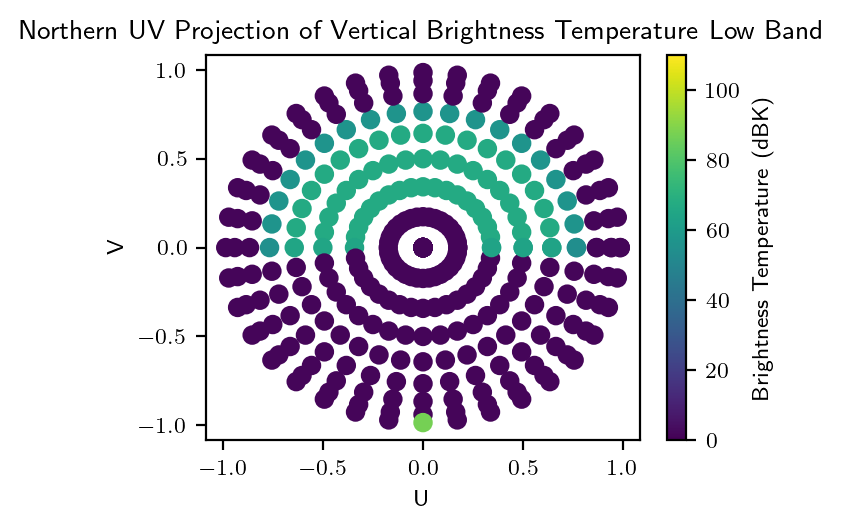

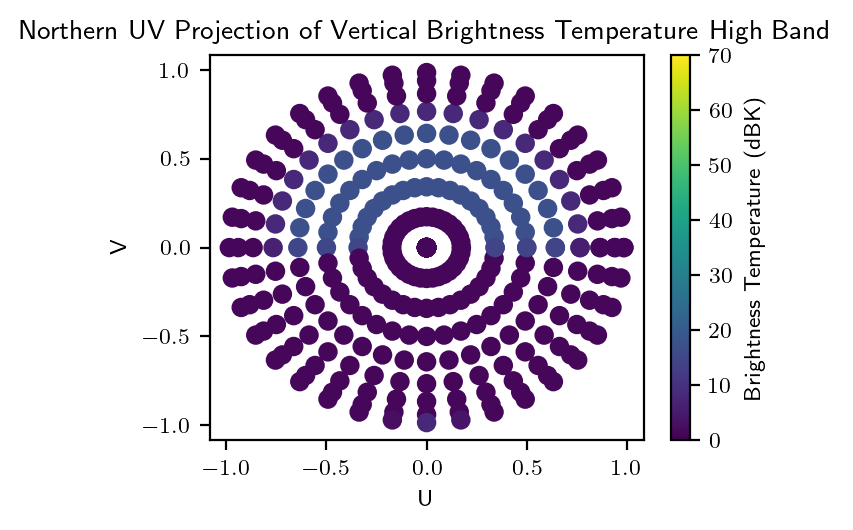

In [19]:
# Set the global theta and phi to the course grid
theta, phi, \
    phi_grid, theta_grid = angle_grid(10, 10).get_angle_grid()

theta_grid_rad = np.deg2rad(theta_grid)
phi_grid_rad = np.deg2rad(phi_grid)

# Plot only the Northern Hemisphere of the brightness temperature
U = (np.sin(theta_grid_rad[0:9]) * np.cos(phi_grid_rad[0:9])).flatten()
V = (np.sin(theta_grid_rad[0:9]) * np.sin(phi_grid_rad[0:9])).flatten()

plt.figure()
plt.scatter(U, V, c=10 * np.log10(T_Bv_low_band.reshape(theta_grid_rad.shape)[0:9].flatten())
    , cmap='viridis', vmin=0, vmax=110)
plt.colorbar(label='Brightness Temperature (dBK)')
plt.xlabel('U')
plt.ylabel('V')
plt.title('Northern UV Projection of Vertical Brightness Temperature Low Band')
plt.show()

# # Plot only the Southern Hemisphere of the brightness temperature
# U = (np.sin(theta_grid_rad[9:]) * np.cos(phi_grid_rad[9:])).flatten()
# V = (np.sin(theta_grid_rad[9:]) * np.sin(phi_grid_rad[9:])).flatten()

# plt.figure()
# plt.scatter(U, V, c=10 * np.log10(T_Bv_low_band.reshape(theta_grid_rad.shape)[9:].flatten())
#     , cmap='viridis', vmin=0, vmax=110)
# plt.colorbar(label='Brightness Temperature (dBK)')
# plt.xlabel('U')
# plt.ylabel('V')
# plt.title('Southern UV Projection of Vertical Brightness Temperature Low Band')
# plt.show()

# Plot only the Northern Hemisphere of the brightness temperature
U = (np.sin(theta_grid_rad[0:9]) * np.cos(phi_grid_rad[0:9])).flatten()
V = (np.sin(theta_grid_rad[0:9]) * np.sin(phi_grid_rad[0:9])).flatten()

plt.figure()
plt.scatter(U, V, c=10 * np.log10(T_Bv_high_band.reshape(theta_grid_rad.shape)[0:9].flatten())
    , cmap='viridis', vmin=0, vmax=70)
plt.colorbar(label='Brightness Temperature (dBK)')
plt.xlabel('U')
plt.ylabel('V')
plt.title('Northern UV Projection of Vertical Brightness Temperature High Band')
plt.show()

# # Plot only the Southern Hemisphere of the brightness temperature
# U = (np.sin(theta_grid_rad[9:]) * np.cos(phi_grid_rad[9:])).flatten()
# V = (np.sin(theta_grid_rad[9:]) * np.sin(phi_grid_rad[9:])).flatten()

# plt.figure()
# plt.scatter(U, V, c=10 * np.log10(T_Bv_high_band.reshape(theta_grid_rad.shape)[9:].flatten())
#     , cmap='viridis', vmin=0, vmax=70)
# plt.colorbar(label='Brightness Temperature (dBK)')
# plt.xlabel('U')
# plt.ylabel('V')
# plt.title('Southern UV Projection of Vertical Brightness Temperature High Band')
plt.show()